This notebook is based on `5.0-ayw-neural-network.ipynb`

## Aim of this notebook

In this notebook we will use a fully connected neural network with 6 hidden layers with each layer having 1825 nodes. All five dataset will be examined separately.

## Results

The simple neural network is unable to detect degradation rates from a normalised power signal to any reasonable precision for all datasets except for basic. This time some minimal preprocessing is used.

Again the soil_weather_extra dataset seem to perform better than soil, weather, or soil_weather. This is probably since soil, weather, and soil_weather datasets don't have enough signals to train in a meaningful way.

As a consequence such neural network can't be used as a stand-alone tool to analyse degradation, however it might be useful in a CODS like pipline, where other methods are used to clean up the data passed to the neural network.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import os
import datetime
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import tensorflow as tf

from src.models.prepare_model import load_PI_data, split_data_training, create_fully_connected_model
from src.models.train_model import train_model
from src.models.predict_model import load_and_predict_model

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
def extract_yr_degrad(avg_power_decay):
    x = np.array([i/365 for i in range(0,len(avg_power_decay))])
    y = np.array(avg_power_decay)
    return np.polyfit(x,y,1)[0]

## Test all of the datasets

In [3]:
# Set up the variables
datasets = [
    ('../data/processed/synthetic_basic_pi_daily.zip', 'basic', 50),
    ('../data/processed/synthetic_soil_pi_daily.zip', 'soil', 50),
   ('../data/processed/synthetic_weather_pi_daily.zip', 'weather', 50),
    ('../data/processed/synthetic_soil_weather_pi_daily.zip', 'soil_weather', 50),
    ('../data/processed/synthetic_soil_weather_pi_daily_extra.zip', 'soil_weather_extra', 100)
]

name = 'fc_6_layers_pre'
signal_length = 1825
nr_epochs = 1000
hidden_layers = [signal_length] * 5

X_tests = {}
y_tests = {}
predictions = {}
ys = {}
rmses = {}

In [4]:
# Run
for dataset in datasets:
    print(f"Processing {dataset[1]}\n")
    
    # Read in the data
    X, y = load_PI_data(dataset[0], dataset[2], 5)
    
    # Some preprocessing
    for i, x in enumerate(X):
        temp = pd.Series(x).rolling(15).apply(np.median, raw=True)
        X[i, :] = temp.bfill()
        
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_data_training(X, y)
    X_tests[dataset[1]] = X_test
    y_tests[dataset[1]] = y_test
    
    # Create the model
    model = create_fully_connected_model(signal_length, signal_length, hidden_layers)
    model_name = name + '_' + dataset[1]
    
    # Get run index
    run_index_path = "./checkpoint/run_index"

    with open(run_index_path, 'r') as f:
        run_index = int(f.readline())
    run_index += 1
    with open(run_index_path, 'w') as f:
        f.write(str(run_index))
    
    # Train the model
    checpoint_path = train_model(model,
                                 X_train,
                                 y_train,
                                 X_valid,
                                 y_valid,
                                 run_index,
                                 model_name,
                                 "./log/" + dataset[1],
                                 "./checkpoint/" + dataset[1],
                                 nr_epochs)
    print(f"Checkpoint for {dataset[1]} dataset is at {checpoint_path}")
    
    # Predict on 
    prediction = load_and_predict_model(checpoint_path, X_test)
    
    # Find RMSE
    model_pred = []
    degradation_rates_test = []
    for i in range(0, len(prediction)):
        model_pred.append(extract_yr_degrad(prediction[i, :]))
        degradation_rates_test.append(extract_yr_degrad(y_test[i]))
    mse = mean_squared_error(model_pred, degradation_rates_test)
    
    rmses[dataset[1]] = np.sqrt(mse)
    print(f"RMSE for {dataset[1]} dataset is at {rmses[dataset[1]]}")    
    predictions[dataset[1]] = prediction
    ys[dataset[1]] = y_test

Processing basic

Epoch 1/1000
2/2 [==============================] - 0s 188ms/step - loss: 0.2932 - val_loss: 0.4492
Epoch 2/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.2931 - val_loss: 0.4956
Epoch 3/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.2814 - val_loss: 0.5391
Epoch 4/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.2682 - val_loss: 0.5621
Epoch 5/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.2561 - val_loss: 0.5756
Epoch 6/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.2456 - val_loss: 0.5618
Epoch 7/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.2384 - val_loss: 0.5579
Epoch 8/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.2328 - val_loss: 0.5518
Epoch 9/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.2282 - val_loss: 0.5446
Epoch 10/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.2237 - val_los

2/2 [==============================] - 0s 58ms/step - loss: 5.6813e-04 - val_loss: 0.0046
Epoch 81/1000
2/2 [==============================] - 0s 55ms/step - loss: 5.5212e-04 - val_loss: 0.0043
Epoch 82/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.3810e-04 - val_loss: 0.0040
Epoch 83/1000
2/2 [==============================] - 0s 62ms/step - loss: 5.1760e-04 - val_loss: 0.0037
Epoch 84/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.0198e-04 - val_loss: 0.0035
Epoch 85/1000
2/2 [==============================] - 0s 53ms/step - loss: 4.8543e-04 - val_loss: 0.0033
Epoch 86/1000
2/2 [==============================] - 0s 55ms/step - loss: 4.6676e-04 - val_loss: 0.0030
Epoch 87/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.5214e-04 - val_loss: 0.0025
Epoch 88/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.3820e-04 - val_loss: 0.0022
Epoch 89/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.26

Epoch 153/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.2011e-04 - val_loss: 1.9551e-04
Epoch 154/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.1716e-04 - val_loss: 1.9118e-04
Epoch 155/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.1440e-04 - val_loss: 1.8677e-04
Epoch 156/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.1193e-04 - val_loss: 1.8250e-04
Epoch 157/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.1186e-04 - val_loss: 1.8226e-04
Epoch 158/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.0891e-04 - val_loss: 1.8107e-04
Epoch 159/1000
2/2 [==============================] - 0s 69ms/step - loss: 1.1000e-04 - val_loss: 1.7636e-04
Epoch 160/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.0782e-04 - val_loss: 1.7528e-04
Epoch 161/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.0460e-04 - val_loss: 1.7460e-04
Epoch 162/1000
2/2 

2/2 [==============================] - 0s 63ms/step - loss: 4.8047e-05 - val_loss: 8.7591e-05
Epoch 227/1000
2/2 [==============================] - 0s 121ms/step - loss: 4.7532e-05 - val_loss: 8.5697e-05
Epoch 228/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.7102e-05 - val_loss: 8.6025e-05
Epoch 229/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.7268e-05 - val_loss: 8.7547e-05
Epoch 230/1000
2/2 [==============================] - 0s 61ms/step - loss: 5.1513e-05 - val_loss: 8.6207e-05
Epoch 231/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.6216e-05 - val_loss: 8.5059e-05
Epoch 232/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.5944e-05 - val_loss: 8.3512e-05
Epoch 233/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.8627e-05 - val_loss: 8.3038e-05
Epoch 234/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.5061e-05 - val_loss: 8.2626e-05
Epoch 235/1000
2/2 [=============

2/2 [==============================] - 0s 59ms/step - loss: 2.6762e-05 - val_loss: 3.9280e-05
Epoch 300/1000
2/2 [==============================] - 4s 2s/step - loss: 2.5996e-05 - val_loss: 3.7907e-05
Epoch 301/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.8578e-05 - val_loss: 3.7160e-05
Epoch 302/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.5581e-05 - val_loss: 3.6561e-05
Epoch 303/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.4621e-05 - val_loss: 3.6326e-05
Epoch 304/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.8171e-05 - val_loss: 3.5364e-05
Epoch 305/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.7814e-05 - val_loss: 3.5775e-05
Epoch 306/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.5553e-05 - val_loss: 3.6321e-05
Epoch 307/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.6666e-05 - val_loss: 3.5987e-05
Epoch 308/1000
2/2 [================

Epoch 371/1000
2/2 [==============================] - 0s 53ms/step - loss: 2.0692e-05 - val_loss: 2.1171e-05
Epoch 372/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.2015e-05 - val_loss: 2.0365e-05
Epoch 373/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.8459e-05 - val_loss: 1.9733e-05
Epoch 374/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.6438e-05 - val_loss: 2.0935e-05
Epoch 375/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.8171e-05 - val_loss: 2.1170e-05
Epoch 376/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.0016e-05 - val_loss: 1.9771e-05
Epoch 377/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.6905e-05 - val_loss: 1.8740e-05
Epoch 378/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.7047e-05 - val_loss: 1.7998e-05
Epoch 379/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.7024e-05 - val_loss: 1.8088e-05
Epoch 380/1000
2/2 

2/2 [==============================] - 0s 57ms/step - loss: 1.4966e-05 - val_loss: 1.5779e-05
Epoch 445/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.4438e-05 - val_loss: 1.3811e-05
Epoch 446/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.2816e-05 - val_loss: 1.2678e-05
Epoch 447/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.2411e-05 - val_loss: 1.2140e-05
Epoch 448/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.3120e-05 - val_loss: 1.2137e-05
Epoch 449/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.2478e-05 - val_loss: 1.1995e-05
Epoch 450/1000
2/2 [==============================] - 4s 2s/step - loss: 1.1917e-05 - val_loss: 1.1757e-05
Epoch 451/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.4526e-05 - val_loss: 1.1569e-05
Epoch 452/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.6034e-05 - val_loss: 1.1631e-05
Epoch 453/1000
2/2 [================

Epoch 516/1000
2/2 [==============================] - 0s 56ms/step - loss: 9.7402e-06 - val_loss: 9.0996e-06
Epoch 517/1000
2/2 [==============================] - 0s 59ms/step - loss: 7.8540e-06 - val_loss: 9.2553e-06
Epoch 518/1000
2/2 [==============================] - 0s 56ms/step - loss: 8.0080e-06 - val_loss: 9.3825e-06
Epoch 519/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.2608e-05 - val_loss: 9.5925e-06
Epoch 520/1000
2/2 [==============================] - 0s 56ms/step - loss: 8.3744e-06 - val_loss: 9.8549e-06
Epoch 521/1000
2/2 [==============================] - 0s 63ms/step - loss: 7.5226e-06 - val_loss: 9.7708e-06
Epoch 522/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.3645e-05 - val_loss: 1.0191e-05
Epoch 523/1000
2/2 [==============================] - 0s 58ms/step - loss: 9.2749e-06 - val_loss: 1.0910e-05
Epoch 524/1000
2/2 [==============================] - 0s 62ms/step - loss: 8.7828e-06 - val_loss: 1.1753e-05
Epoch 525/1000
2/2 

2/2 [==============================] - 0s 57ms/step - loss: 9.9016e-06 - val_loss: 7.2704e-06
Epoch 590/1000
2/2 [==============================] - 0s 59ms/step - loss: 7.6832e-06 - val_loss: 7.6968e-06
Epoch 591/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.9222e-06 - val_loss: 7.5627e-06
Epoch 592/1000
2/2 [==============================] - 0s 59ms/step - loss: 6.6172e-06 - val_loss: 7.2686e-06
Epoch 593/1000
2/2 [==============================] - 0s 57ms/step - loss: 8.8655e-06 - val_loss: 6.9101e-06
Epoch 594/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.5764e-05 - val_loss: 6.5955e-06
Epoch 595/1000
2/2 [==============================] - 0s 55ms/step - loss: 9.4210e-06 - val_loss: 7.6569e-06
Epoch 596/1000
2/2 [==============================] - 0s 55ms/step - loss: 9.6815e-06 - val_loss: 9.3181e-06
Epoch 597/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.3277e-05 - val_loss: 1.0423e-05
Epoch 598/1000
2/2 [==============

Epoch 661/1000
2/2 [==============================] - 0s 61ms/step - loss: 9.1354e-06 - val_loss: 6.8114e-06
Epoch 662/1000
2/2 [==============================] - 0s 58ms/step - loss: 7.8959e-06 - val_loss: 8.0995e-06
Epoch 663/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.9884e-06 - val_loss: 9.8527e-06
Epoch 664/1000
2/2 [==============================] - 0s 64ms/step - loss: 8.4961e-06 - val_loss: 1.1530e-05
Epoch 665/1000
2/2 [==============================] - 0s 59ms/step - loss: 9.8367e-06 - val_loss: 1.0478e-05
Epoch 666/1000
2/2 [==============================] - 0s 58ms/step - loss: 8.9617e-06 - val_loss: 8.1051e-06
Epoch 667/1000
2/2 [==============================] - 0s 56ms/step - loss: 8.3116e-06 - val_loss: 6.8119e-06
Epoch 668/1000
2/2 [==============================] - 0s 59ms/step - loss: 6.1161e-06 - val_loss: 6.6300e-06
Epoch 669/1000
2/2 [==============================] - 0s 58ms/step - loss: 7.1960e-06 - val_loss: 6.2813e-06
Epoch 670/1000
2/2 

2/2 [==============================] - 0s 56ms/step - loss: 4.6658e-06 - val_loss: 5.2485e-06
Epoch 735/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.8365e-06 - val_loss: 5.8966e-06
Epoch 736/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.8338e-06 - val_loss: 5.0365e-06
Epoch 737/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.4996e-06 - val_loss: 4.9571e-06
Epoch 738/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.6520e-06 - val_loss: 4.6884e-06
Epoch 739/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.6929e-06 - val_loss: 4.4454e-06
Epoch 740/1000
2/2 [==============================] - 0s 62ms/step - loss: 4.6896e-06 - val_loss: 5.4168e-06
Epoch 741/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.8154e-06 - val_loss: 6.3892e-06
Epoch 742/1000
2/2 [==============================] - 0s 57ms/step - loss: 7.6533e-06 - val_loss: 6.3020e-06
Epoch 743/1000
2/2 [==============

Epoch 806/1000
2/2 [==============================] - 0s 63ms/step - loss: 8.1449e-06 - val_loss: 6.8591e-06
Epoch 807/1000
2/2 [==============================] - 0s 140ms/step - loss: 6.5842e-06 - val_loss: 6.8046e-06
Epoch 808/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.9393e-06 - val_loss: 7.9237e-06
Epoch 809/1000
2/2 [==============================] - 0s 55ms/step - loss: 7.3347e-06 - val_loss: 6.6693e-06
Epoch 810/1000
2/2 [==============================] - 0s 58ms/step - loss: 5.0793e-06 - val_loss: 4.4465e-06
Epoch 811/1000
2/2 [==============================] - 0s 53ms/step - loss: 5.5884e-06 - val_loss: 4.5750e-06
Epoch 812/1000
2/2 [==============================] - 0s 57ms/step - loss: 9.5105e-06 - val_loss: 5.0481e-06
Epoch 813/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.3077e-05 - val_loss: 5.7253e-06
Epoch 814/1000
2/2 [==============================] - 0s 56ms/step - loss: 9.7571e-06 - val_loss: 5.5504e-06
Epoch 815/1000
2/2

2/2 [==============================] - 0s 56ms/step - loss: 1.0477e-05 - val_loss: 1.1387e-05
Epoch 880/1000
2/2 [==============================] - 0s 61ms/step - loss: 9.9668e-06 - val_loss: 7.7237e-06
Epoch 881/1000
2/2 [==============================] - 0s 56ms/step - loss: 7.3494e-06 - val_loss: 5.1347e-06
Epoch 882/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.8816e-06 - val_loss: 4.0415e-06
Epoch 883/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.4883e-06 - val_loss: 4.2602e-06
Epoch 884/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.0944e-06 - val_loss: 5.8809e-06
Epoch 885/1000
2/2 [==============================] - 0s 56ms/step - loss: 6.8304e-06 - val_loss: 6.2018e-06
Epoch 886/1000
2/2 [==============================] - 0s 54ms/step - loss: 6.2766e-06 - val_loss: 4.0837e-06
Epoch 887/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.7171e-06 - val_loss: 3.9512e-06
Epoch 888/1000
2/2 [==============

Epoch 951/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.1135e-06 - val_loss: 5.9743e-06
Epoch 952/1000
2/2 [==============================] - 0s 59ms/step - loss: 6.9353e-06 - val_loss: 6.2968e-06
Epoch 953/1000
2/2 [==============================] - 0s 57ms/step - loss: 9.6679e-06 - val_loss: 4.8974e-06
Epoch 954/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.0472e-06 - val_loss: 3.7963e-06
Epoch 955/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.0609e-05 - val_loss: 3.9710e-06
Epoch 956/1000
2/2 [==============================] - 0s 59ms/step - loss: 6.8091e-06 - val_loss: 4.6051e-06
Epoch 957/1000
2/2 [==============================] - 0s 60ms/step - loss: 8.9625e-06 - val_loss: 2.8117e-06
Epoch 958/1000
2/2 [==============================] - 0s 59ms/step - loss: 5.9910e-06 - val_loss: 4.5616e-06
Epoch 959/1000
2/2 [==============================] - 0s 63ms/step - loss: 4.6239e-06 - val_loss: 5.1147e-06
Epoch 960/1000
2/2 

2/2 [==============================] - 0s 58ms/step - loss: 0.1780 - val_loss: 0.5519
Epoch 26/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.1729 - val_loss: 0.5352
Epoch 27/1000
2/2 [==============================] - 0s 54ms/step - loss: 0.1667 - val_loss: 0.6523
Epoch 28/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.1579 - val_loss: 0.5982
Epoch 29/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.1656 - val_loss: 0.7913
Epoch 30/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.1515 - val_loss: 0.6179
Epoch 31/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.1402 - val_loss: 0.4911
Epoch 32/1000
2/2 [==============================] - 0s 55ms/step - loss: 0.1299 - val_loss: 0.5816
Epoch 33/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.1204 - val_loss: 0.5183
Epoch 34/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.1116 - val_loss: 0.4667
Epoch 35/1000


Epoch 102/1000
2/2 [==============================] - 0s 54ms/step - loss: 0.0018 - val_loss: 7.6504e-04
Epoch 103/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.0018 - val_loss: 7.4564e-04
Epoch 104/1000
2/2 [==============================] - 0s 58ms/step - loss: 8.1942e-04 - val_loss: 7.5113e-04
Epoch 105/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.8902e-04 - val_loss: 8.2525e-04
Epoch 106/1000
2/2 [==============================] - 0s 55ms/step - loss: 5.6162e-04 - val_loss: 8.7124e-04
Epoch 107/1000
2/2 [==============================] - 0s 56ms/step - loss: 7.5122e-04 - val_loss: 8.3069e-04
Epoch 108/1000
2/2 [==============================] - 0s 57ms/step - loss: 7.9070e-04 - val_loss: 7.8330e-04
Epoch 109/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.2297e-04 - val_loss: 8.1127e-04
Epoch 110/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.6819e-04 - val_loss: 8.3480e-04
Epoch 111/1000
2/2 [=======

Epoch 176/1000
2/2 [==============================] - 0s 63ms/step - loss: 2.6480e-04 - val_loss: 3.8051e-04
Epoch 177/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.4841e-04 - val_loss: 3.8362e-04
Epoch 178/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.5035e-04 - val_loss: 4.0333e-04
Epoch 179/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.7455e-04 - val_loss: 4.3534e-04
Epoch 180/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.7080e-04 - val_loss: 4.5188e-04
Epoch 181/1000
2/2 [==============================] - 0s 68ms/step - loss: 2.8720e-04 - val_loss: 4.8258e-04
Epoch 182/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.7340e-04 - val_loss: 5.0186e-04
Epoch 183/1000
2/2 [==============================] - 0s 66ms/step - loss: 2.5434e-04 - val_loss: 4.5799e-04
Epoch 184/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.5764e-04 - val_loss: 4.1770e-04
Epoch 185/1000
2/2 

2/2 [==============================] - 0s 57ms/step - loss: 1.7936e-04 - val_loss: 2.7579e-04
Epoch 250/1000
2/2 [==============================] - 4s 2s/step - loss: 1.8307e-04 - val_loss: 2.9055e-04
Epoch 251/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.7848e-04 - val_loss: 3.0436e-04
Epoch 252/1000
2/2 [==============================] - 0s 63ms/step - loss: 1.7913e-04 - val_loss: 3.1650e-04
Epoch 253/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.9030e-04 - val_loss: 3.3630e-04
Epoch 254/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.8408e-04 - val_loss: 3.4854e-04
Epoch 255/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.7969e-04 - val_loss: 3.6067e-04
Epoch 256/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.9054e-04 - val_loss: 4.1093e-04
Epoch 257/1000
2/2 [==============================] - 0s 63ms/step - loss: 1.8859e-04 - val_loss: 5.2873e-04
Epoch 258/1000
2/2 [================

Epoch 321/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.5113e-04 - val_loss: 2.1461e-04
Epoch 322/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.5120e-04 - val_loss: 2.2430e-04
Epoch 323/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.5998e-04 - val_loss: 2.3931e-04
Epoch 324/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.6443e-04 - val_loss: 2.5389e-04
Epoch 325/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.5402e-04 - val_loss: 2.4529e-04
Epoch 326/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.6270e-04 - val_loss: 2.3078e-04
Epoch 327/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.5462e-04 - val_loss: 2.1735e-04
Epoch 328/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.5340e-04 - val_loss: 2.1479e-04
Epoch 329/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.5346e-04 - val_loss: 2.2010e-04
Epoch 330/1000
2/2 

2/2 [==============================] - 0s 57ms/step - loss: 1.2447e-04 - val_loss: 2.3406e-04
Epoch 395/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.1962e-04 - val_loss: 2.4880e-04
Epoch 396/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.2816e-04 - val_loss: 2.6640e-04
Epoch 397/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.2777e-04 - val_loss: 2.5183e-04
Epoch 398/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.1787e-04 - val_loss: 2.4075e-04
Epoch 399/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.2105e-04 - val_loss: 2.4996e-04
Epoch 400/1000
2/2 [==============================] - 4s 2s/step - loss: 1.1366e-04 - val_loss: 2.4284e-04
Epoch 401/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.1512e-04 - val_loss: 2.3582e-04
Epoch 402/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.1320e-04 - val_loss: 2.2110e-04
Epoch 403/1000
2/2 [================

Epoch 466/1000
2/2 [==============================] - 0s 64ms/step - loss: 1.3159e-04 - val_loss: 2.7759e-04
Epoch 467/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.1649e-04 - val_loss: 2.4302e-04
Epoch 468/1000
2/2 [==============================] - 0s 63ms/step - loss: 1.2408e-04 - val_loss: 2.1902e-04
Epoch 469/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.3106e-04 - val_loss: 2.0203e-04
Epoch 470/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.2493e-04 - val_loss: 1.9653e-04
Epoch 471/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.4167e-04 - val_loss: 2.2475e-04
Epoch 472/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.6489e-04 - val_loss: 2.7809e-04
Epoch 473/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.7372e-04 - val_loss: 3.1044e-04
Epoch 474/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.4069e-04 - val_loss: 3.0174e-04
Epoch 475/1000
2/2 

2/2 [==============================] - 0s 58ms/step - loss: 3.0434e-04 - val_loss: 6.5176e-04
Epoch 540/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.5501e-04 - val_loss: 6.0725e-04
Epoch 541/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.6727e-04 - val_loss: 5.8743e-04
Epoch 542/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.5776e-04 - val_loss: 5.4354e-04
Epoch 543/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.6317e-04 - val_loss: 5.0906e-04
Epoch 544/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.5964e-04 - val_loss: 4.6171e-04
Epoch 545/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.6026e-04 - val_loss: 4.3457e-04
Epoch 546/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.5906e-04 - val_loss: 4.3986e-04
Epoch 547/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.4400e-04 - val_loss: 4.5128e-04
Epoch 548/1000
2/2 [==============

Epoch 611/1000
2/2 [==============================] - 0s 63ms/step - loss: 2.6268e-04 - val_loss: 3.2617e-04
Epoch 612/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.7664e-04 - val_loss: 3.0245e-04
Epoch 613/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.3778e-04 - val_loss: 3.0200e-04
Epoch 614/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.4956e-04 - val_loss: 3.7842e-04
Epoch 615/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.6879e-04 - val_loss: 4.4368e-04
Epoch 616/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.6771e-04 - val_loss: 4.7106e-04
Epoch 617/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.8305e-04 - val_loss: 4.2699e-04
Epoch 618/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.6317e-04 - val_loss: 4.3941e-04
Epoch 619/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.7289e-04 - val_loss: 3.9809e-04
Epoch 620/1000
2/2 

2/2 [==============================] - 0s 59ms/step - loss: 2.4297e-04 - val_loss: 2.8648e-04
Epoch 685/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.4740e-04 - val_loss: 2.8077e-04
Epoch 686/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.6014e-04 - val_loss: 2.7092e-04
Epoch 687/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.4648e-04 - val_loss: 2.6287e-04
Epoch 688/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.4952e-04 - val_loss: 2.6037e-04
Epoch 689/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.4714e-04 - val_loss: 2.6076e-04
Epoch 690/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.3592e-04 - val_loss: 2.6353e-04
Epoch 691/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.3680e-04 - val_loss: 2.7539e-04
Epoch 692/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.3842e-04 - val_loss: 2.9856e-04
Epoch 693/1000
2/2 [==============

Epoch 756/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.4612e-04 - val_loss: 2.9871e-04
Epoch 757/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.4570e-04 - val_loss: 2.9250e-04
Epoch 758/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.6608e-04 - val_loss: 2.8269e-04
Epoch 759/1000
2/2 [==============================] - 0s 59ms/step - loss: 2.8349e-04 - val_loss: 2.7573e-04
Epoch 760/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.3904e-04 - val_loss: 2.8943e-04
Checkpoint for soil dataset is at ./checkpoint/soil/fc_6_layers_pre_soil_run022.h5
RMSE for soil dataset is at 0.003815797825696583
Processing weather

Epoch 1/1000
2/2 [==============================] - 0s 194ms/step - loss: 0.2941 - val_loss: 0.3724
Epoch 2/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.2893 - val_loss: 0.4049
Epoch 3/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.2656 - val_loss: 0.4597
Epoch

Epoch 74/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 75/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 76/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 77/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 78/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 79/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 80/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 81/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 82/1000
2/2 [==============================] - 0s 55ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 83/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.0015 - val_loss: 8.1444e

2/2 [==============================] - 0s 58ms/step - loss: 3.3816e-04 - val_loss: 7.1813e-04
Epoch 150/1000
2/2 [==============================] - 4s 2s/step - loss: 2.6897e-04 - val_loss: 7.2390e-04
Epoch 151/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.4941e-04 - val_loss: 7.2074e-04
Epoch 152/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.2859e-04 - val_loss: 7.1507e-04
Epoch 153/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.5277e-04 - val_loss: 7.0598e-04
Epoch 154/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.3126e-04 - val_loss: 7.0040e-04
Epoch 155/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.2145e-04 - val_loss: 6.9438e-04
Epoch 156/1000
2/2 [==============================] - 0s 53ms/step - loss: 2.1462e-04 - val_loss: 6.8740e-04
Epoch 157/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.2579e-04 - val_loss: 6.8395e-04
Epoch 158/1000
2/2 [================

Epoch 221/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.5657e-04 - val_loss: 4.4355e-04
Epoch 222/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.5583e-04 - val_loss: 4.1879e-04
Epoch 223/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.5080e-04 - val_loss: 3.9528e-04
Epoch 224/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.5962e-04 - val_loss: 3.8338e-04
Epoch 225/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.5660e-04 - val_loss: 3.8778e-04
Epoch 226/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.4259e-04 - val_loss: 3.8816e-04
Epoch 227/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.3961e-04 - val_loss: 3.7643e-04
Epoch 228/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.5627e-04 - val_loss: 3.7201e-04
Epoch 229/1000
2/2 [==============================] - 0s 152ms/step - loss: 1.3670e-04 - val_loss: 3.7196e-04
Epoch 230/1000
2/2

2/2 [==============================] - 0s 57ms/step - loss: 1.9007e-04 - val_loss: 2.9914e-04
Epoch 295/1000
2/2 [==============================] - 0s 63ms/step - loss: 1.3103e-04 - val_loss: 2.8556e-04
Epoch 296/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.2539e-04 - val_loss: 2.8480e-04
Epoch 297/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.2260e-04 - val_loss: 2.9454e-04
Epoch 298/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.2253e-04 - val_loss: 3.0141e-04
Epoch 299/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.2341e-04 - val_loss: 3.0561e-04
Epoch 300/1000
2/2 [==============================] - 4s 2s/step - loss: 1.1824e-04 - val_loss: 2.7696e-04
Epoch 301/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.1771e-04 - val_loss: 2.4130e-04
Epoch 302/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.1457e-04 - val_loss: 2.1901e-04
Epoch 303/1000
2/2 [================

Epoch 366/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.7063e-04 - val_loss: 2.7541e-04
Epoch 367/1000
2/2 [==============================] - 0s 59ms/step - loss: 9.9675e-05 - val_loss: 2.9538e-04
Epoch 368/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.0424e-04 - val_loss: 3.2275e-04
Epoch 369/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.1123e-04 - val_loss: 3.4349e-04
Epoch 370/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.1184e-04 - val_loss: 3.2010e-04
Epoch 371/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.0753e-04 - val_loss: 2.8568e-04
Epoch 372/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.3967e-04 - val_loss: 2.5653e-04
Epoch 373/1000
2/2 [==============================] - 0s 53ms/step - loss: 1.0615e-04 - val_loss: 2.2685e-04
Epoch 374/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.0040e-04 - val_loss: 2.1120e-04
Epoch 375/1000
2/2 

2/2 [==============================] - 0s 57ms/step - loss: 9.3375e-05 - val_loss: 2.0142e-04
Epoch 440/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.0044e-04 - val_loss: 1.9499e-04
Epoch 441/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.3017e-04 - val_loss: 1.9759e-04
Epoch 442/1000
2/2 [==============================] - 0s 57ms/step - loss: 9.1788e-05 - val_loss: 2.0862e-04
Epoch 443/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.0059e-04 - val_loss: 2.0484e-04
Epoch 444/1000
2/2 [==============================] - 0s 54ms/step - loss: 9.7961e-05 - val_loss: 1.9083e-04
Epoch 445/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.0125e-04 - val_loss: 1.7626e-04
Epoch 446/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.0130e-04 - val_loss: 1.6094e-04
Epoch 447/1000
2/2 [==============================] - 0s 60ms/step - loss: 9.3698e-05 - val_loss: 1.4963e-04
Epoch 448/1000
2/2 [==============

2/2 [==============================] - 0s 59ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 512/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.2246e-04 - val_loss: 0.0271
Epoch 513/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.6732e-04 - val_loss: 0.0109
Epoch 514/1000
2/2 [==============================] - 0s 61ms/step - loss: 2.5777e-04 - val_loss: 0.0064
Epoch 515/1000
2/2 [==============================] - 0s 60ms/step - loss: 4.1870e-04 - val_loss: 0.0151
Epoch 516/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.3548e-04 - val_loss: 0.0162
Epoch 517/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.7449e-04 - val_loss: 0.0036
Epoch 518/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.2980e-04 - val_loss: 0.0012
Epoch 519/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.0980e-04 - val_loss: 0.0011
Epoch 520/1000
2/2 [==============================] - 0s 56ms/step - loss:

Epoch 586/1000
2/2 [==============================] - 0s 58ms/step - loss: 7.5000e-04 - val_loss: 7.9446e-04
Epoch 587/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.1410e-04 - val_loss: 9.1583e-04
Epoch 588/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.9730e-04 - val_loss: 9.3114e-04
Epoch 589/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.5451e-04 - val_loss: 9.3949e-04
Epoch 590/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.2657e-04 - val_loss: 9.5574e-04
Epoch 591/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.7993e-04 - val_loss: 9.7464e-04
Epoch 592/1000
2/2 [==============================] - 0s 60ms/step - loss: 3.8241e-04 - val_loss: 9.7825e-04
Epoch 593/1000
2/2 [==============================] - 0s 60ms/step - loss: 3.7032e-04 - val_loss: 9.8223e-04
Epoch 594/1000
2/2 [==============================] - 0s 62ms/step - loss: 6.0006e-04 - val_loss: 9.9045e-04
Epoch 595/1000
2/2 

Epoch 658/1000
2/2 [==============================] - 0s 60ms/step - loss: 5.3307e-04 - val_loss: 5.1542e-04
Epoch 659/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.8265e-04 - val_loss: 5.8277e-04
Epoch 660/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.3347e-04 - val_loss: 6.2825e-04
Epoch 661/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.8643e-04 - val_loss: 6.0867e-04
Epoch 662/1000
2/2 [==============================] - 0s 54ms/step - loss: 4.4731e-04 - val_loss: 5.8751e-04
Epoch 663/1000
2/2 [==============================] - 0s 55ms/step - loss: 3.9564e-04 - val_loss: 6.1668e-04
Epoch 664/1000
2/2 [==============================] - 0s 54ms/step - loss: 3.5117e-04 - val_loss: 6.1045e-04
Epoch 665/1000
2/2 [==============================] - 0s 62ms/step - loss: 3.4656e-04 - val_loss: 6.1689e-04
Epoch 666/1000
2/2 [==============================] - 0s 61ms/step - loss: 3.5030e-04 - val_loss: 6.2422e-04
Epoch 667/1000
2/2 

2/2 [==============================] - 0s 56ms/step - loss: 2.1278e-04 - val_loss: 2.8024e-04
Epoch 732/1000
2/2 [==============================] - 0s 55ms/step - loss: 6.3367e-04 - val_loss: 2.8033e-04
Epoch 733/1000
2/2 [==============================] - 0s 63ms/step - loss: 2.2001e-04 - val_loss: 3.6144e-04
Epoch 734/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.2449e-04 - val_loss: 4.0673e-04
Epoch 735/1000
2/2 [==============================] - 0s 60ms/step - loss: 3.6341e-04 - val_loss: 4.4355e-04
Epoch 736/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.2945e-04 - val_loss: 5.9036e-04
Epoch 737/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.9423e-04 - val_loss: 8.2336e-04
Epoch 738/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.4855e-04 - val_loss: 0.0010
Epoch 739/1000
2/2 [==============================] - 0s 55ms/step - loss: 3.5837e-04 - val_loss: 9.0773e-04
Epoch 740/1000
2/2 [==================

2/2 [==============================] - 0s 56ms/step - loss: 0.1366 - val_loss: 0.5503
Epoch 32/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.1459 - val_loss: 0.1643
Epoch 33/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.1204 - val_loss: 0.0703
Epoch 34/1000
2/2 [==============================] - 0s 54ms/step - loss: 0.1176 - val_loss: 0.1830
Epoch 35/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.1100 - val_loss: 0.1713
Epoch 36/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0997 - val_loss: 0.0986
Epoch 37/1000
2/2 [==============================] - 0s 55ms/step - loss: 0.0921 - val_loss: 0.1599
Epoch 38/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0832 - val_loss: 0.2838
Epoch 39/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.0769 - val_loss: 0.2486
Epoch 40/1000
2/2 [==============================] - 0s 55ms/step - loss: 0.0693 - val_loss: 0.1269
Epoch 41/1000


2/2 [==============================] - 0s 60ms/step - loss: 6.4512e-04 - val_loss: 7.8214e-04
Epoch 109/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.1611e-04 - val_loss: 6.2283e-04
Epoch 110/1000
2/2 [==============================] - 0s 58ms/step - loss: 6.1001e-04 - val_loss: 5.4902e-04
Epoch 111/1000
2/2 [==============================] - 0s 62ms/step - loss: 9.0235e-04 - val_loss: 5.4713e-04
Epoch 112/1000
2/2 [==============================] - 0s 58ms/step - loss: 6.6566e-04 - val_loss: 6.9818e-04
Epoch 113/1000
2/2 [==============================] - 0s 58ms/step - loss: 6.1501e-04 - val_loss: 9.1543e-04
Epoch 114/1000
2/2 [==============================] - 0s 56ms/step - loss: 6.3786e-04 - val_loss: 0.0010
Epoch 115/1000
2/2 [==============================] - 0s 60ms/step - loss: 8.8156e-04 - val_loss: 0.0011
Epoch 116/1000
2/2 [==============================] - 0s 62ms/step - loss: 6.4017e-04 - val_loss: 0.0013
Epoch 117/1000
2/2 [==========================

2/2 [==============================] - 0s 55ms/step - loss: 5.3077e-04 - val_loss: 4.8809e-04
Epoch 183/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0038 - val_loss: 9.7329e-04
Epoch 184/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.7355e-04 - val_loss: 8.4665e-04
Epoch 185/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.8951e-04 - val_loss: 4.6086e-04
Epoch 186/1000
2/2 [==============================] - 0s 55ms/step - loss: 4.1941e-04 - val_loss: 5.5818e-04
Epoch 187/1000
2/2 [==============================] - 0s 55ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 188/1000
2/2 [==============================] - 0s 55ms/step - loss: 8.1538e-04 - val_loss: 0.0081
Epoch 189/1000
2/2 [==============================] - 0s 60ms/step - loss: 6.2879e-04 - val_loss: 0.0071
Epoch 190/1000
2/2 [==============================] - 0s 61ms/step - loss: 9.6634e-04 - val_loss: 0.0145
Epoch 191/1000
2/2 [==============================] - 0s 5

Epoch 255/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.0987e-04 - val_loss: 2.7666e-04
Epoch 256/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.2031e-04 - val_loss: 2.7435e-04
Epoch 257/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.1340e-04 - val_loss: 2.7084e-04
Epoch 258/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.3405e-04 - val_loss: 2.5458e-04
Epoch 259/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.9648e-04 - val_loss: 2.6601e-04
Epoch 260/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.9756e-04 - val_loss: 3.0144e-04
Epoch 261/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.9754e-04 - val_loss: 2.9240e-04
Epoch 262/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.8721e-04 - val_loss: 2.7334e-04
Epoch 263/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.9096e-04 - val_loss: 2.6326e-04
Epoch 264/1000
2/2 

2/2 [==============================] - 0s 56ms/step - loss: 2.4800e-04 - val_loss: 3.3504e-04
Epoch 329/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.3422e-04 - val_loss: 3.3617e-04
Epoch 330/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.5616e-04 - val_loss: 3.3391e-04
Epoch 331/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.3371e-04 - val_loss: 3.4446e-04
Epoch 332/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.4792e-04 - val_loss: 3.5332e-04
Epoch 333/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.3566e-04 - val_loss: 3.5690e-04
Epoch 334/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.1666e-04 - val_loss: 3.5675e-04
Epoch 335/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.2888e-04 - val_loss: 3.5706e-04
Epoch 336/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.2573e-04 - val_loss: 3.5804e-04
Epoch 337/1000
2/2 [==============

2/2 [==============================] - 4s 2s/step - loss: 1.6195e-04 - val_loss: 1.6832e-04
Epoch 401/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.6577e-04 - val_loss: 1.7278e-04
Epoch 402/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.7106e-04 - val_loss: 1.7787e-04
Epoch 403/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.5478e-04 - val_loss: 1.7988e-04
Epoch 404/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.5764e-04 - val_loss: 1.7612e-04
Epoch 405/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.5168e-04 - val_loss: 1.7093e-04
Epoch 406/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.5356e-04 - val_loss: 1.7020e-04
Epoch 407/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.6666e-04 - val_loss: 1.8357e-04
Epoch 408/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.6197e-04 - val_loss: 1.8350e-04
Epoch 409/1000
2/2 [================

2/2 [==============================] - 0s 59ms/step - loss: 1.8740e-04 - val_loss: 2.4003e-04
Epoch 474/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.8853e-04 - val_loss: 2.3541e-04
Epoch 475/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.8227e-04 - val_loss: 2.2604e-04
Epoch 476/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.9304e-04 - val_loss: 2.2534e-04
Epoch 477/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.8127e-04 - val_loss: 2.1992e-04
Epoch 478/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.6617e-04 - val_loss: 2.1586e-04
Epoch 479/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.6941e-04 - val_loss: 2.1448e-04
Epoch 480/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.6507e-04 - val_loss: 2.1761e-04
Epoch 481/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.7491e-04 - val_loss: 2.1703e-04
Epoch 482/1000
2/2 [==============

2/2 [==============================] - 0s 64ms/step - loss: 2.8805e-04 - val_loss: 5.3640e-04
Epoch 547/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.6367e-04 - val_loss: 5.1507e-04
Epoch 548/1000
2/2 [==============================] - 0s 60ms/step - loss: 3.3914e-04 - val_loss: 4.5786e-04
Epoch 549/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.5904e-04 - val_loss: 4.3075e-04
Epoch 550/1000
2/2 [==============================] - 4s 2s/step - loss: 4.5987e-04 - val_loss: 4.2660e-04
Epoch 551/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.3107e-04 - val_loss: 4.8825e-04
Epoch 552/1000
2/2 [==============================] - 0s 60ms/step - loss: 4.3617e-04 - val_loss: 5.4211e-04
Epoch 553/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.9112e-04 - val_loss: 5.1028e-04
Epoch 554/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.9743e-04 - val_loss: 4.5197e-04
Epoch 555/1000
2/2 [================

2/2 [==============================] - 0s 56ms/step - loss: 3.8846e-04 - val_loss: 5.9794e-04
Epoch 619/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.3410e-04 - val_loss: 5.8930e-04
Epoch 620/1000
2/2 [==============================] - 0s 60ms/step - loss: 4.2766e-04 - val_loss: 5.8853e-04
Epoch 621/1000
2/2 [==============================] - 0s 64ms/step - loss: 3.9899e-04 - val_loss: 5.8476e-04
Epoch 622/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.1864e-04 - val_loss: 5.9012e-04
Epoch 623/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.0355e-04 - val_loss: 5.9113e-04
Epoch 624/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.0945e-04 - val_loss: 5.9323e-04
Epoch 625/1000
2/2 [==============================] - 0s 60ms/step - loss: 3.9098e-04 - val_loss: 5.9537e-04
Epoch 626/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.1541e-04 - val_loss: 5.9173e-04
Epoch 627/1000
2/2 [==============

2/2 [==============================] - 0s 55ms/step - loss: 4.5382e-04 - val_loss: 5.0272e-04
Epoch 692/1000
2/2 [==============================] - 0s 55ms/step - loss: 4.1009e-04 - val_loss: 4.5828e-04
Epoch 693/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.1484e-04 - val_loss: 4.7719e-04
Epoch 694/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.1821e-04 - val_loss: 5.3421e-04
Epoch 695/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.0095e-04 - val_loss: 5.1410e-04
Epoch 696/1000
2/2 [==============================] - 0s 60ms/step - loss: 4.0719e-04 - val_loss: 5.3240e-04
Epoch 697/1000
2/2 [==============================] - 0s 54ms/step - loss: 3.8779e-04 - val_loss: 4.7759e-04
Epoch 698/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.9934e-04 - val_loss: 4.1053e-04
Epoch 699/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.3514e-04 - val_loss: 3.8562e-04
Epoch 700/1000
2/2 [==============

3/3 [==============================] - 0s 73ms/step - loss: 0.1203 - val_loss: 0.1543
Epoch 16/1000
3/3 [==============================] - 0s 74ms/step - loss: 0.1007 - val_loss: 0.1383
Epoch 17/1000
3/3 [==============================] - 0s 74ms/step - loss: 0.0821 - val_loss: 0.1432
Epoch 18/1000
3/3 [==============================] - 0s 78ms/step - loss: 0.0656 - val_loss: 0.0917
Epoch 19/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.0494 - val_loss: 0.1633
Epoch 20/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.0376 - val_loss: 0.0251
Epoch 21/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.0333 - val_loss: 0.1698
Epoch 22/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.0213 - val_loss: 0.0083
Epoch 23/1000
3/3 [==============================] - 0s 77ms/step - loss: 0.0175 - val_loss: 0.0401
Epoch 24/1000
3/3 [==============================] - 0s 74ms/step - loss: 0.0137 - val_loss: 0.0043
Epoch 25/1000


3/3 [==============================] - 0s 73ms/step - loss: 1.5853e-04 - val_loss: 1.8384e-04
Epoch 88/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.5648e-04 - val_loss: 1.8576e-04
Epoch 89/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.5196e-04 - val_loss: 1.8140e-04
Epoch 90/1000
3/3 [==============================] - 0s 68ms/step - loss: 1.4960e-04 - val_loss: 1.7780e-04
Epoch 91/1000
3/3 [==============================] - 0s 70ms/step - loss: 1.4311e-04 - val_loss: 1.7661e-04
Epoch 92/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.4150e-04 - val_loss: 1.7453e-04
Epoch 93/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.4019e-04 - val_loss: 1.7191e-04
Epoch 94/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.4136e-04 - val_loss: 1.7635e-04
Epoch 95/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.3902e-04 - val_loss: 1.7953e-04
Epoch 96/1000
3/3 [=======================

3/3 [==============================] - 0s 72ms/step - loss: 5.2844e-05 - val_loss: 1.1032e-04
Epoch 160/1000
3/3 [==============================] - 0s 71ms/step - loss: 5.4243e-05 - val_loss: 1.1452e-04
Epoch 161/1000
3/3 [==============================] - 0s 71ms/step - loss: 5.5874e-05 - val_loss: 1.2371e-04
Epoch 162/1000
3/3 [==============================] - 0s 79ms/step - loss: 7.0057e-05 - val_loss: 1.1509e-04
Epoch 163/1000
3/3 [==============================] - 0s 74ms/step - loss: 5.8961e-05 - val_loss: 1.0545e-04
Epoch 164/1000
3/3 [==============================] - 0s 73ms/step - loss: 5.8237e-05 - val_loss: 1.0573e-04
Epoch 165/1000
3/3 [==============================] - 0s 73ms/step - loss: 6.7465e-05 - val_loss: 1.0425e-04
Epoch 166/1000
3/3 [==============================] - 0s 72ms/step - loss: 5.0225e-05 - val_loss: 1.0690e-04
Epoch 167/1000
3/3 [==============================] - 7s 2s/step - loss: 5.6170e-05 - val_loss: 1.0683e-04
Epoch 168/1000
3/3 [================

3/3 [==============================] - 0s 71ms/step - loss: 2.2101e-05 - val_loss: 7.1111e-05
Epoch 233/1000
3/3 [==============================] - 0s 73ms/step - loss: 2.1286e-05 - val_loss: 6.9611e-05
Epoch 234/1000
3/3 [==============================] - 0s 74ms/step - loss: 2.4885e-05 - val_loss: 8.4520e-05
Epoch 235/1000
3/3 [==============================] - 0s 70ms/step - loss: 2.2123e-05 - val_loss: 1.2339e-04
Epoch 236/1000
3/3 [==============================] - 0s 72ms/step - loss: 2.1195e-05 - val_loss: 1.5168e-04
Epoch 237/1000
3/3 [==============================] - 0s 70ms/step - loss: 2.7883e-05 - val_loss: 1.6616e-04
Epoch 238/1000
3/3 [==============================] - 0s 71ms/step - loss: 2.9463e-05 - val_loss: 1.7930e-04
Epoch 239/1000
3/3 [==============================] - 0s 71ms/step - loss: 2.4745e-05 - val_loss: 1.7169e-04
Epoch 240/1000
3/3 [==============================] - 0s 76ms/step - loss: 2.5047e-05 - val_loss: 1.6885e-04
Epoch 241/1000
3/3 [==============

3/3 [==============================] - 0s 70ms/step - loss: 1.9336e-05 - val_loss: 7.2916e-05
Epoch 303/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.6123e-05 - val_loss: 6.5767e-05
Epoch 304/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.4787e-05 - val_loss: 6.3084e-05
Epoch 305/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.6628e-05 - val_loss: 6.2225e-05
Epoch 306/1000
3/3 [==============================] - 0s 79ms/step - loss: 1.5029e-05 - val_loss: 7.0279e-05
Epoch 307/1000
3/3 [==============================] - 0s 77ms/step - loss: 1.6709e-05 - val_loss: 7.4003e-05
Epoch 308/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.9926e-05 - val_loss: 7.3482e-05
Epoch 309/1000
3/3 [==============================] - 0s 74ms/step - loss: 2.8523e-05 - val_loss: 6.3182e-05
Epoch 310/1000
3/3 [==============================] - 0s 78ms/step - loss: 2.6702e-05 - val_loss: 6.4248e-05
Epoch 311/1000
3/3 [==============

3/3 [==============================] - 0s 73ms/step - loss: 1.3114e-05 - val_loss: 8.6807e-05
Epoch 373/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.3028e-05 - val_loss: 7.0898e-05
Epoch 374/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.2370e-05 - val_loss: 6.7788e-05
Epoch 375/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.3505e-05 - val_loss: 6.3421e-05
Epoch 376/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.0623e-05 - val_loss: 5.9183e-05
Epoch 377/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.1101e-05 - val_loss: 6.1935e-05
Epoch 378/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.0835e-05 - val_loss: 6.6765e-05
Epoch 379/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.3332e-05 - val_loss: 6.6047e-05
Epoch 380/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.7035e-05 - val_loss: 6.9766e-05
Epoch 381/1000
3/3 [==============

Epoch 444/1000
3/3 [==============================] - 0s 70ms/step - loss: 1.1157e-05 - val_loss: 1.0407e-04
Epoch 445/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.8204e-05 - val_loss: 1.0504e-04
Epoch 446/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.7246e-05 - val_loss: 1.1822e-04
Epoch 447/1000
3/3 [==============================] - 0s 71ms/step - loss: 1.6016e-05 - val_loss: 1.0749e-04
Epoch 448/1000
3/3 [==============================] - 0s 68ms/step - loss: 1.2586e-05 - val_loss: 1.0036e-04
Epoch 449/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.3224e-05 - val_loss: 9.7440e-05
Epoch 450/1000
3/3 [==============================] - 0s 69ms/step - loss: 2.0731e-05 - val_loss: 8.5977e-05
Epoch 451/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.4986e-05 - val_loss: 7.5892e-05
Epoch 452/1000
3/3 [==============================] - 0s 70ms/step - loss: 1.1963e-05 - val_loss: 6.7284e-05
Epoch 453/1000
3/3 

3/3 [==============================] - 0s 76ms/step - loss: 7.5557e-06 - val_loss: 8.1542e-05
Epoch 518/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.6405e-05 - val_loss: 7.3670e-05
Epoch 519/1000
3/3 [==============================] - 0s 76ms/step - loss: 1.0975e-05 - val_loss: 6.6418e-05
Epoch 520/1000
3/3 [==============================] - 0s 73ms/step - loss: 9.8141e-06 - val_loss: 7.4197e-05
Epoch 521/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.0178e-05 - val_loss: 8.0443e-05
Epoch 522/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.6485e-05 - val_loss: 6.5520e-05
Epoch 523/1000
3/3 [==============================] - 0s 73ms/step - loss: 8.5512e-06 - val_loss: 7.2966e-05
Epoch 524/1000
3/3 [==============================] - 0s 72ms/step - loss: 2.1517e-05 - val_loss: 6.6950e-05
Epoch 525/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.3472e-05 - val_loss: 7.6321e-05
Epoch 526/1000
3/3 [==============

3/3 [==============================] - 0s 70ms/step - loss: 7.8516e-06 - val_loss: 7.5396e-05
Epoch 588/1000
3/3 [==============================] - 0s 72ms/step - loss: 1.6641e-05 - val_loss: 7.2356e-05
Epoch 589/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.1474e-05 - val_loss: 1.4303e-04
Epoch 590/1000
3/3 [==============================] - 0s 70ms/step - loss: 1.0742e-05 - val_loss: 1.7592e-04
Epoch 591/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.3463e-05 - val_loss: 1.0125e-04
Epoch 592/1000
3/3 [==============================] - 0s 71ms/step - loss: 8.8973e-06 - val_loss: 8.5577e-05
Epoch 593/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.0144e-05 - val_loss: 8.6940e-05
Epoch 594/1000
3/3 [==============================] - 0s 71ms/step - loss: 8.8464e-06 - val_loss: 7.3210e-05
Epoch 595/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.1328e-05 - val_loss: 8.8531e-05
Epoch 596/1000
3/3 [==============

In [5]:
pickle.dump((predictions, ys, rmses, X_tests, y_tests), open(name + "_outcomes.p", "wb" ))

# Investigate the results 

In [6]:
# What's the meaning of these RMSEs?
for dataset in datasets:
    print(f"RMSE for normalised {dataset[1]} dataset is at {rmses[dataset[1]]*100:0.3f}%/year") 

RMSE for normalised basic dataset is at 0.080%/year
RMSE for normalised soil dataset is at 0.382%/year
RMSE for normalised weather dataset is at 0.627%/year
RMSE for normalised soil_weather dataset is at 0.695%/year
RMSE for normalised soil_weather_extra dataset is at 0.265%/year


Displaying basic dataset


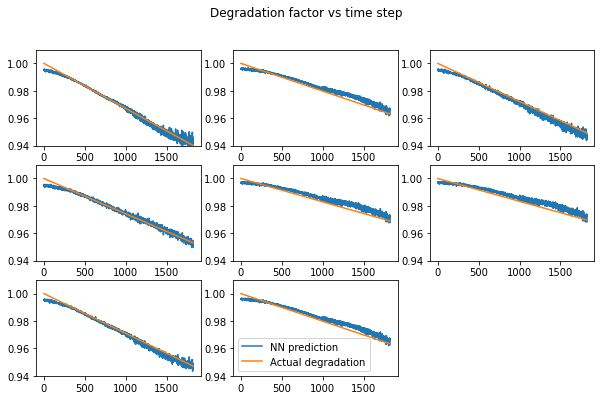

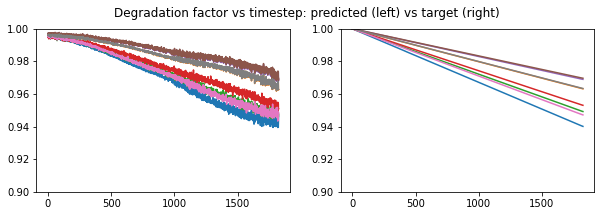

Displaying soil dataset


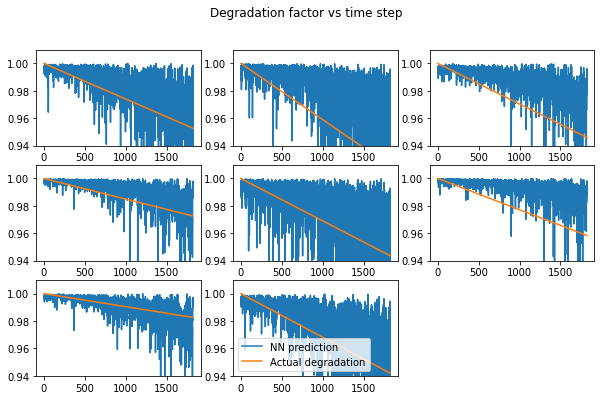

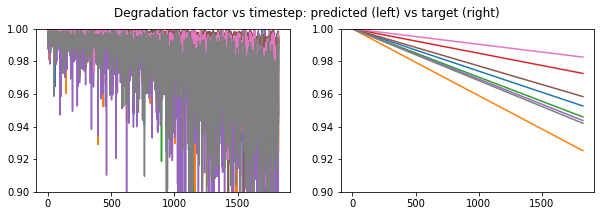

Displaying weather dataset


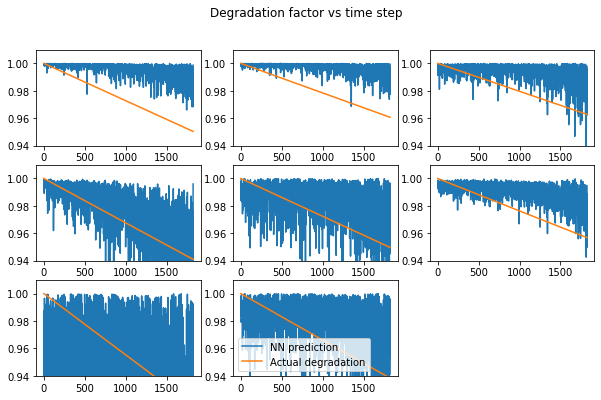

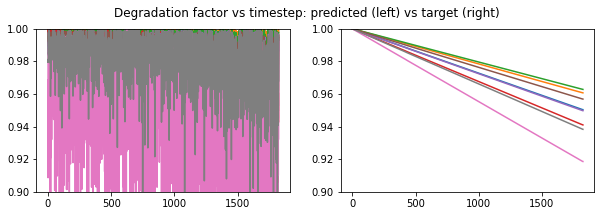

Displaying soil_weather dataset


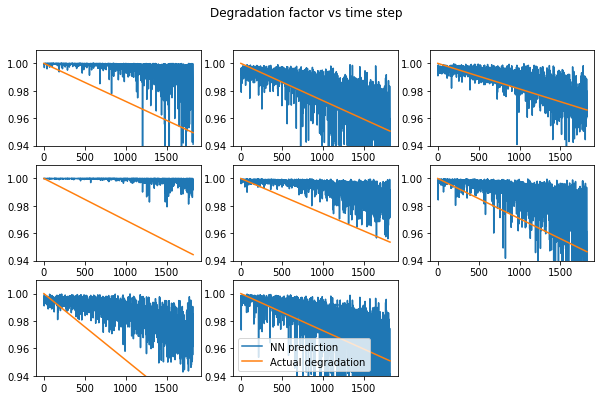

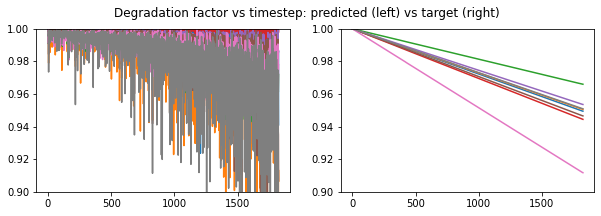

Displaying soil_weather_extra dataset


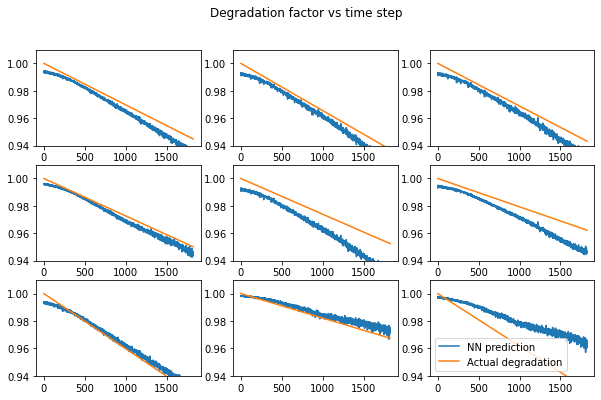

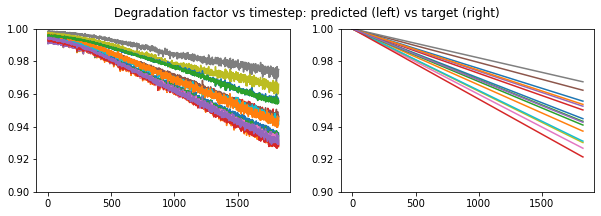

In [7]:
# Visualizing the predictions.
for dataset in datasets: 
    print(f"Displaying {dataset[1]} dataset")
    
    prediction = predictions[dataset[1]]
    y_test = y_tests[dataset[1]]
    
    plt.figure(figsize=(10,6))
    plt.tight_layout()
    plt.suptitle("Degradation factor vs time step")
    for i in range(0, min(len(prediction), 9)):
        plt.subplot(3,3,i+1)
        plt.ylim(0.94,1.01)
        plt.plot([x for x in prediction[i]])
        plt.plot([x for x in y_test[i]])
    plt.legend(['NN prediction','Actual degradation'])
    plt.show()

    plt.figure(figsize=(10,3))
    plt.suptitle("Degradation factor vs timestep: predicted (left) vs target (right)")
    plt.subplot(1,2,1)
    plt.ylim(0.90,1)
    for i in range(0,len(prediction)):
        plt.plot(prediction[i])
    plt.subplot(1,2,2)
    plt.ylim(0.90,1)
    for i in range(0,len(y_test)):
        plt.plot(y_test[i])
    plt.show()

Displaying basic dataset
RMSE is 0.0032563852366288035


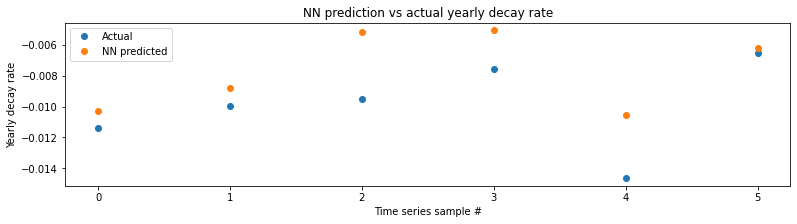

Displaying soil dataset
RMSE is 0.005463737716082134


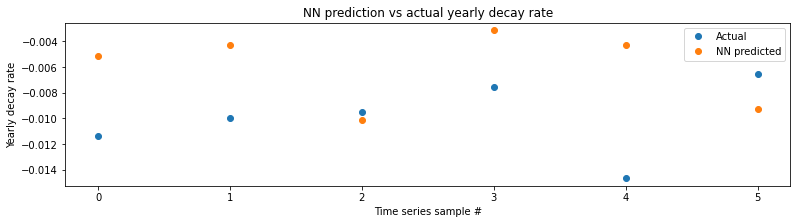

Displaying weather dataset
RMSE is 0.006906007616231428


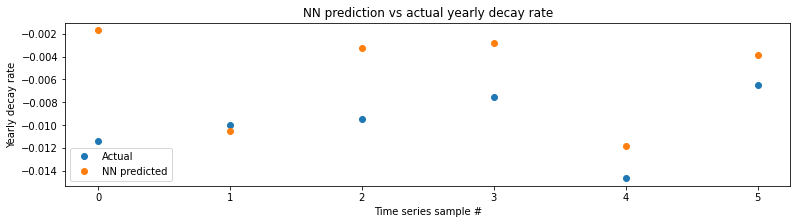

Displaying soil_weather dataset
RMSE is 0.006688578242834004


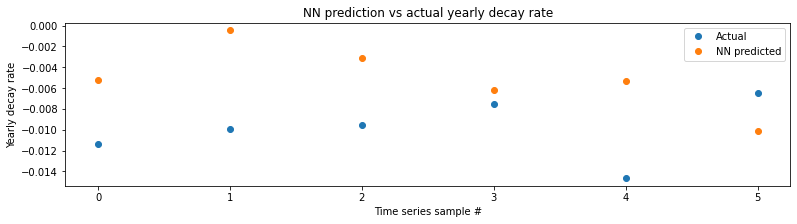

Displaying soil_weather_extra dataset
RMSE is 0.002654478628573688


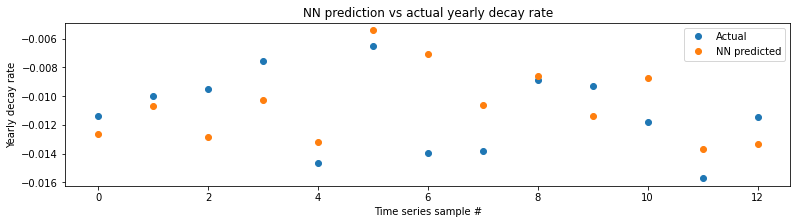

In [8]:
for dataset in datasets:
    # Plotting decay rate (predicted vs target)
    
    print(f"Displaying {dataset[1]} dataset")
    prediction = predictions[dataset[1]]
    
    model_pred = []
    degradation_rates_test = []
    for i in range(0, len(prediction)):
        model_pred.append(extract_yr_degrad(prediction[i, :]))
        degradation_rates_test.append(extract_yr_degrad(y_test[i]))
    mse = mean_squared_error(model_pred, degradation_rates_test)
    print(f"RMSE is {np.sqrt(mse)}")
    
    plt.figure(figsize=(13,3))
    plt.plot(degradation_rates_test[2:50], 'o')
    plt.plot(model_pred[2:50], 'o')
    plt.xlabel("Time series sample #")
    plt.ylabel("Yearly decay rate")
    plt.title("NN prediction vs actual yearly decay rate")
    plt.legend(["Actual","NN predicted"])
    plt.show()

Displaying basic dataset


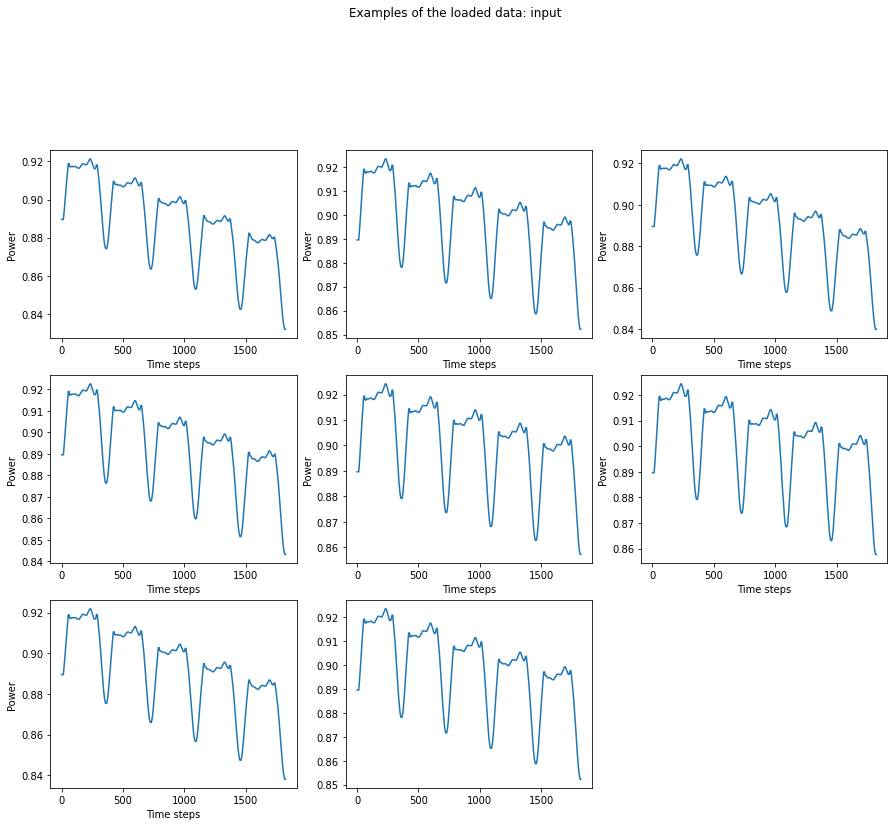

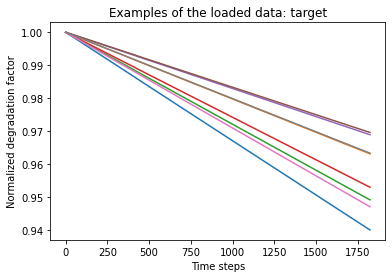

Displaying soil dataset


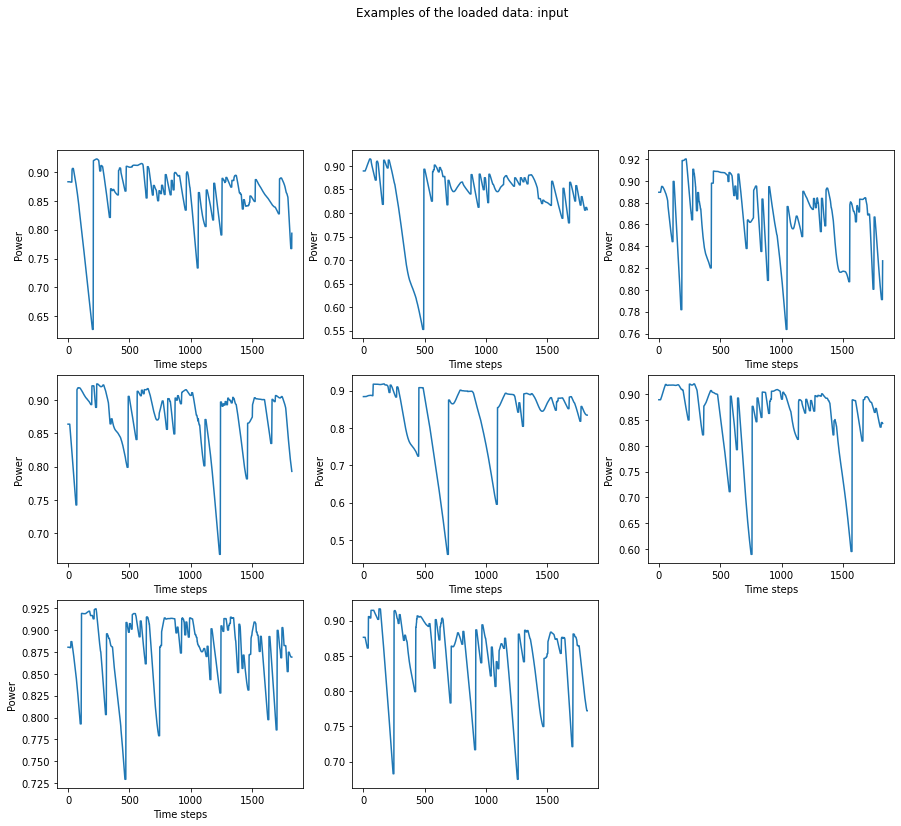

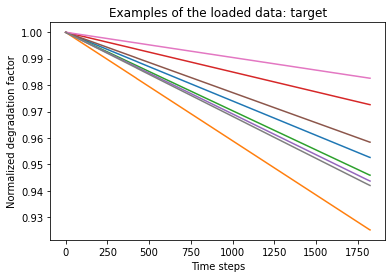

Displaying weather dataset


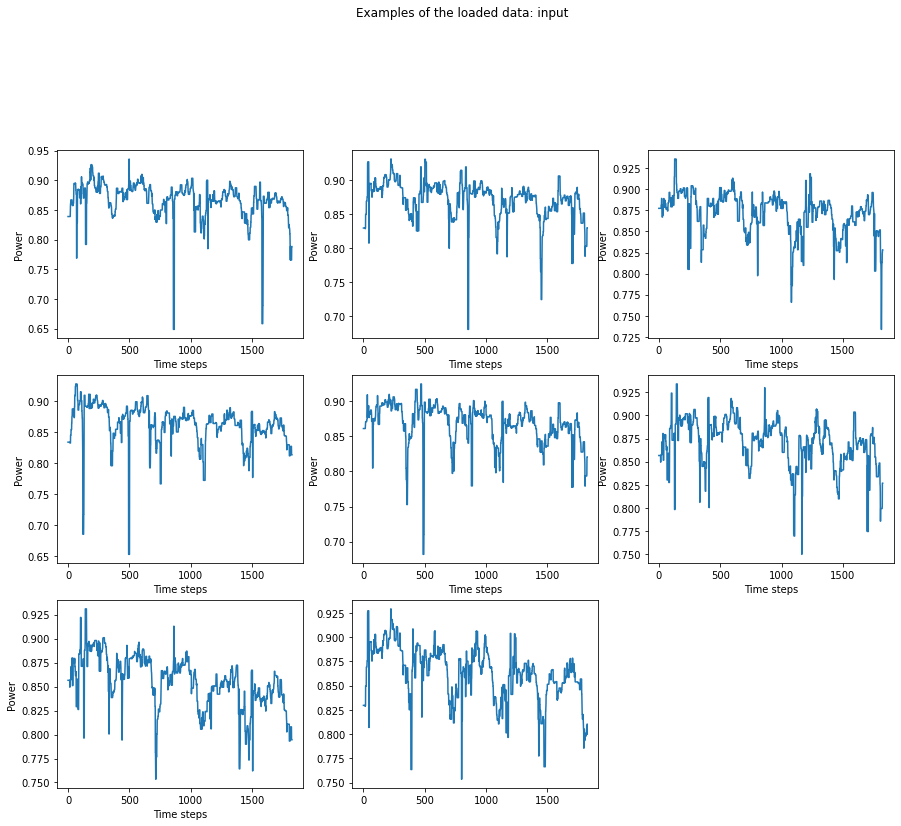

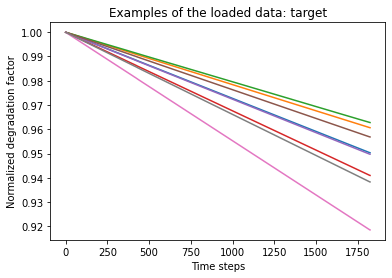

Displaying soil_weather dataset


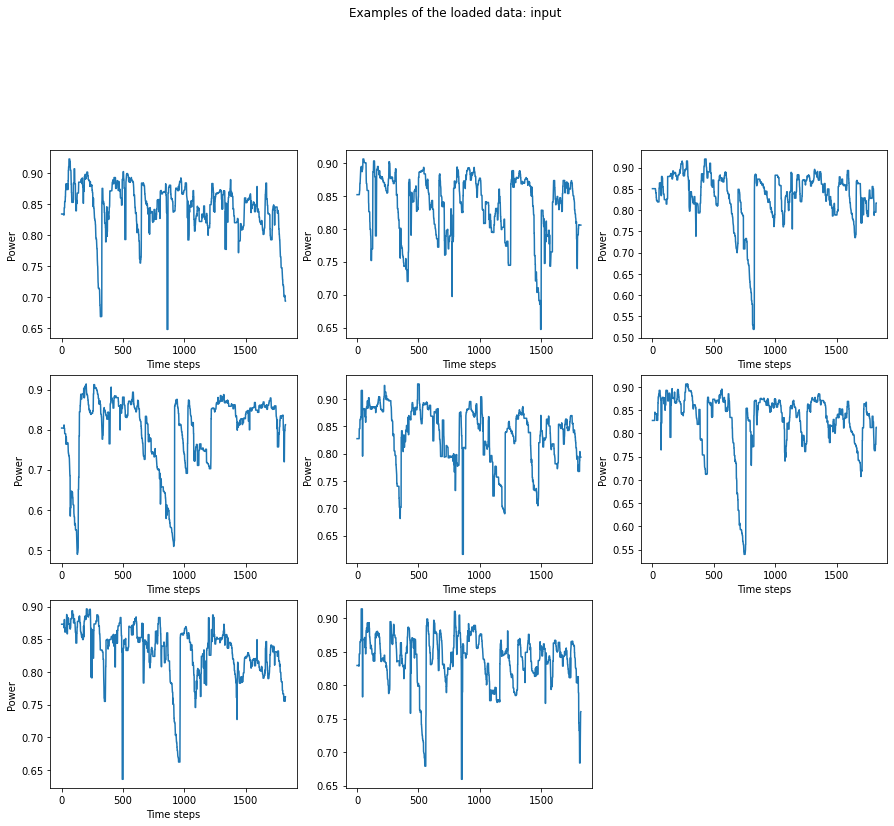

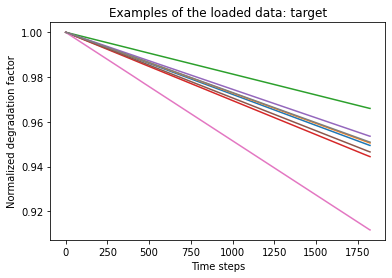

Displaying soil_weather_extra dataset


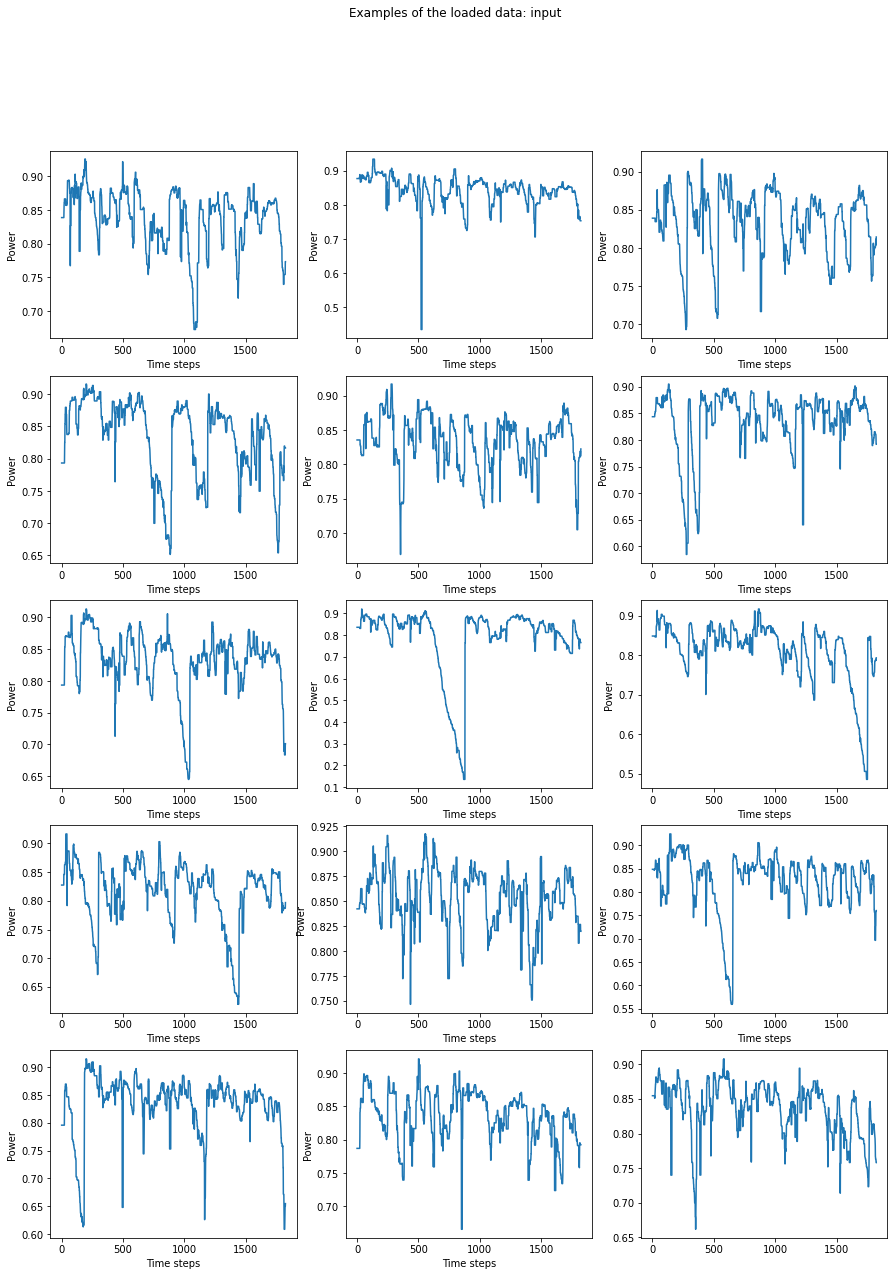

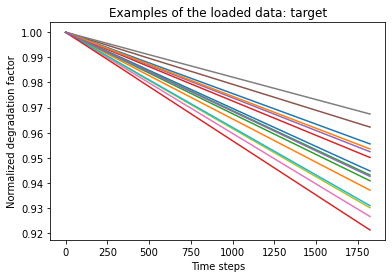

In [9]:
for dataset in datasets:
    print(f"Displaying {dataset[1]} dataset")
    X = X_tests[dataset[1]]
    y = y_tests[dataset[1]]
    
    plt.figure(figsize=(15,20))
    plt.suptitle("Examples of the loaded data: input")
    for i,s in enumerate(X):
        plt.xlabel("Time steps")
        plt.ylabel("Power")
        plt.subplot(5,3,i+1)
        plt.plot(s)
    plt.show()

    plt.figure()
    plt.title("Examples of the loaded data: target")
    plt.xlabel("Time steps")
    plt.ylabel("Normalized degradation factor")
    for s in y:
        plt.plot(s)
    plt.show()